# Data exploration

We'll start by having a look at the data set. The ZooScanSet consists of 1,433,278 images of objects. Mostly classified as plankton, although significant parts of the data consist of *detritus*, *fiber detritus* or *badfocus__artefact* - as well as other less prominent categories that may not be called species. For the classifier, it will of course be necessary to recognize these so they're not mistaken for other species.

From the **ZooScan** manual, available at [https://sites.google.com/view/piqv/instruments-manuals], we know that all images are produced using an instrument much like a flatbed scanner. We assume,therefore, that sizes are comparable between images, and that any size variance in the data is due to actual size variance or possibly technical/labelling errors.

Images are all 8-bit single channel (gray scale) JPEG compressed images. This will need to be taken into consideration when using a pre-built architecture.


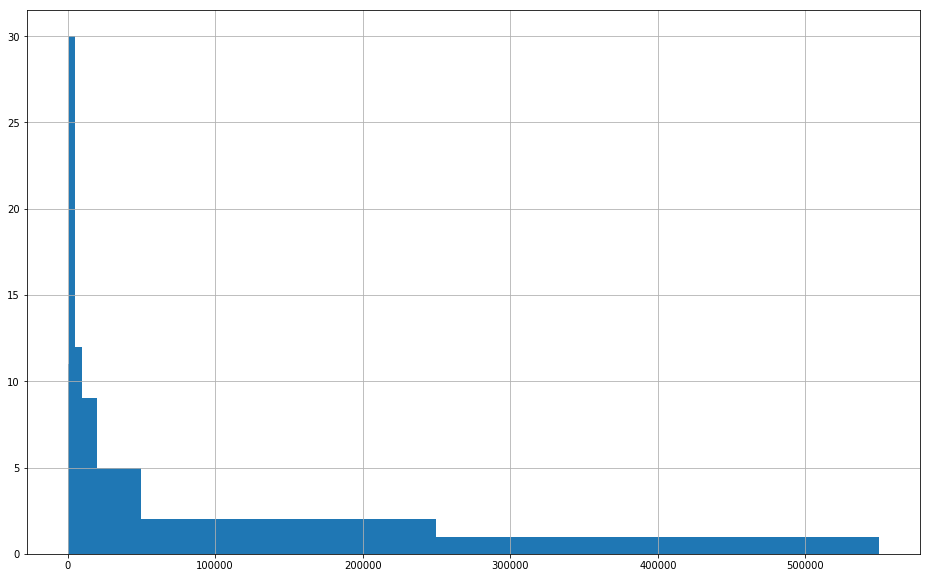

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# load data
taxa = pd.read_csv('../../data/zooscannet/ZooScanSet/taxa.csv', usecols=["objid","taxon"])

# we first have a look at the data.
taxa_distribution = taxa['taxon'].value_counts()

# look at the frequency distribution
#print(taxa_distribution)

taxa['taxon'].value_counts().hist(bins=[0,250,500,1000,5000,10000,20000,50000,100000,250000,550000],
                                  figsize=(16,10))



## A closer look at the frequency distribution

From the histogram above, we see that about 30 of 93 the data categories have less than 250 samples. If we include two more bins (< 1000 samples) we are at 51 of 93 bins. There are problems with this rather strong inbalance in the data:

* Model training will strongly emphasize the dominant classes
* For inference or testing, it is likely that we'll miss out on many of the rare classes, poor recall. This will be both due to lack of samples for evaluation (i.e. if you select 2% of 39 samples of Ctenophora it won't really tell you a lot) and a the imbalance in training.
* The model would also in a sence perform well (high accuracy) if it strongly prefers the dominant classes for classification, after all predicting "detritus" in any case would be correct in over 1/3 of the samples. We may be wary of many false positives for the dominant classes - a low precision.

### Handling the class imbalance
(Inspired by [https://towardsdatascience.com/deep-learning-unbalanced-training-data-solve-it-like-this-6c528e9efea6])

We have a few options:
* Cull the dominant categories down to the frequency of the less common ones
* Resample the less common categories to reuse the data
* Grow the less common categories by synthetisizing samples. This would be like a data augmentation, though selectively applied where it is perceived to be needed.

The first thing we can do, for starters, is to reduce the problem somewhat by only including the forty most abundant categories as suggested in the assignment. 


Index(['detritus', 'Calanoida', 'badfocus__artefact', 'fiber__detritus',
       'Oithonidae', 'Acartiidae', 'Chaetognatha', 'Calanidae', 'Evadne',
       'Oikopleuridae', 'Phaeodaria', 'egg__other', 'Ostracoda',
       'Coscinodiscus', 'multiple__other', 'Oncaeidae', 'bubble',
       'Limacinidae', 'Corycaeidae', 'nauplii__Crustacea', 'cyphonaute',
       'Temoridae', 'Salpida', 'Penilia', 'Noctiluca', 'zoea__Decapoda',
       'nauplii__Cirripedia', 'Foraminifera', 'nectophore__Diphyidae',
       'Brachyura', 'tail__Appendicularia', 'Centropagidae', 'Eucalanidae',
       'Haloptilus', 'Bivalvia__Mollusca', 'calyptopsis', 'Decapoda',
       'artefact', 'Doliolida', 'eudoxie__Diphyidae'],
      dtype='object')


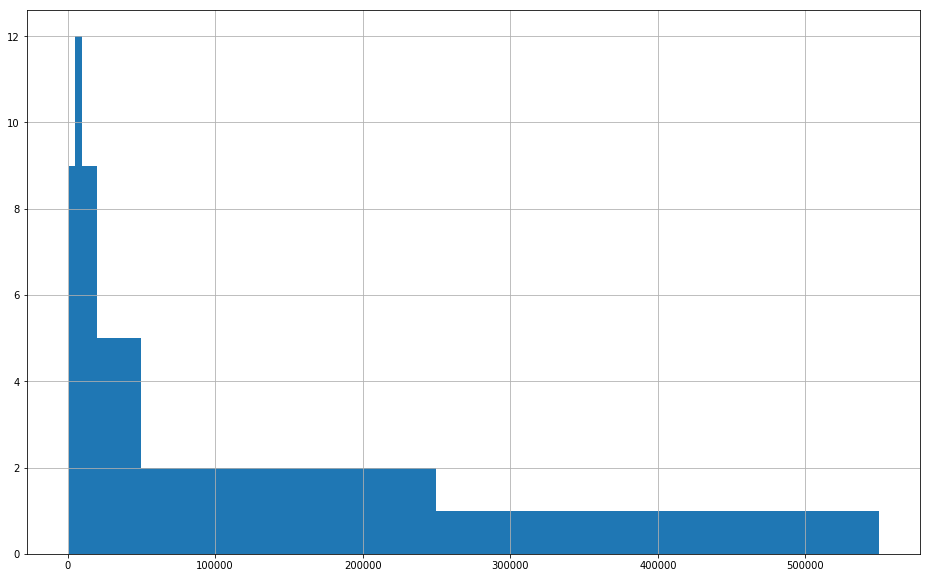

In [3]:
# only the most common categories please
top_taxa_labels = taxa_distribution[:40]
print(top_taxa_labels.index)

# reduce the data set to this
reduced = taxa.loc[taxa['taxon'].isin(top_taxa_labels.index)]

# have a look at the new distribution as above

#print(reduced['taxon'].value_counts())

reduced['taxon'].value_counts().hist(bins=[0,250,500,1000,5000,10000,20000,50000,100000,250000,550000],
                                  figsize=(16,10))



For now, we will use the first option above. We will generate balanced test sets by down sampling the bigger ones.

In [43]:
# downsample the data to a fully balanced set

downsampled = pd.DataFrame()
for label in top_taxa_labels.index:
    
    this_category = reduced.loc[reduced['taxon'] == label].sample(n=100) #using a low n for demo, running code uses 3455
    downsampled = pd.concat([downsampled, this_category])
    print(label + ' - ' + str(np.shape(this_category)[0]))


detritus - 100
Calanoida - 100
badfocus__artefact - 100
fiber__detritus - 100
Oithonidae - 100
Acartiidae - 100
Chaetognatha - 100
Calanidae - 100
Evadne - 100
Oikopleuridae - 100
Phaeodaria - 100
egg__other - 100
Ostracoda - 100
Coscinodiscus - 100
multiple__other - 100
Oncaeidae - 100
bubble - 100
Limacinidae - 100
Corycaeidae - 100
nauplii__Crustacea - 100
cyphonaute - 100
Temoridae - 100
Salpida - 100
Penilia - 100
Noctiluca - 100
zoea__Decapoda - 100
nauplii__Cirripedia - 100
Foraminifera - 100
nectophore__Diphyidae - 100
Brachyura - 100
tail__Appendicularia - 100
Centropagidae - 100
Eucalanidae - 100
Haloptilus - 100
Bivalvia__Mollusca - 100
calyptopsis - 100
Decapoda - 100
artefact - 100
Doliolida - 100
eudoxie__Diphyidae - 100


In [44]:
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
lb = preprocessing.LabelBinarizer()

X = downsampled[['objid']]
y = downsampled[['taxon']]

#X = downsampled
#y = pd.get_dummies(downsampled['taxon'], sparse=False).values

le.fit(np.unique(downsampled['taxon']))
lb.fit(le.transform(np.unique(downsampled['taxon'])))

#y = le.transform(downsampled['taxon'])
#y = lb.fit_transform(y)

# split into training and test data
X_train, X_test, y_train, y_test = train_test_split(X,y, train_size=0.6, random_state=42, stratify=y)
#print(le.inverse_transform(y_train))

/home/havard/anaconda3/envs/inf368/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [45]:
import numpy as np
import keras
from PIL import Image
import cv2

      
class DataGenerator(keras.utils.Sequence):
    """
    Data generator for image data, based on:
    https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly

    Modified to be more pandas friendly and to import images using pillow
    """

    'Generates data for Keras'
    def __init__(self, list_IDs, labels, lenc, lbin, batch_size=32, dim=(224,224), n_channels=3,
                 n_classes=93, shuffle=False, testing=False):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.labels = labels
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.on_epoch_end()
        self.lenc = lenc
        self.lbin = lbin
        self.basepath = '../../data/zooscannet/ZooScanSet/imgs/'
        self.testing = testing

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        
        # Find list of IDs
        list_IDs_temp = [self.list_IDs.index[k] for k in indexes]                
        
        # we need to pass the index somehow as well..
        
        # Generate data
        if (self.testing):
             X=self.__data_generation(list_IDs_temp)
             return X
        else:
            X, y = self.__data_generation(list_IDs_temp)
            return X, y
        

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def load_image(self, infilename ) :
        img = Image.open( infilename )
        img.load()
        #not good resizing, prbly
        img = img.resize((224,224), Image.BICUBIC)        
        data = np.asarray( img, dtype="int32").reshape(224,224,1)
        return data
            
    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.empty((self.batch_size, self.dim[0], self.dim[1], self.n_channels))
        y = np.empty((self.batch_size, self.n_classes), dtype=str)

        # Generate data
        #print(self.labels)
        #print(list_IDs_temp)
        for i, ID in enumerate(list_IDs_temp):
            # Store sample            
            path = self.basepath + str(self.labels.loc[ID]['taxon']) + '/' + str(self.list_IDs.loc[ID]['objid']) + '.jpg'
            #print(path)
            img = self.load_image(path)
            X[i,] = img

            if (self.testing == False):
                # Store class, first need to one hot encode it using the received encoders
                named_class=self.labels.loc[ID]['taxon']
                labeled_class=self.lenc.transform([named_class])
                onehot_class =  self.lbin.transform([labeled_class])                        
                y[i] = onehot_class
            
        if (self.testing):
            return X
        else:
            return X, y

In [46]:
from keras.applications.resnet50 import ResNet50
from keras.preprocessing import image
from keras.applications.resnet50 import preprocess_input, decode_predictions
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
import numpy as np
from keras import backend as K

K.clear_session()
print('Training on '+str(np.shape(X_train)[0]) +' samples')
# Parameters
params = {'dim': (224,224),
          'batch_size': 64,
          'n_classes': 40,
          'n_channels': 3,
          'shuffle': False}

params_test = {'dim': (224,224),
          'batch_size': 64,
          'n_classes': 40,
          'n_channels': 3,
          'shuffle': False}

base_model = ResNet50(weights='imagenet', include_top=False)

# add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)

# let's add a fully-connected layer
x = Dense(1024, activation='relu')(x)

# and a logistic layer -- let's say we have 200 classes
predictions = Dense(40, activation='softmax')(x)

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional InceptionV3 layers
for layer in base_model.layers:
    layer.trainable = False

# compile the model (should be done *after* setting layers to non-trainable)
model.compile(optimizer='rmsprop', loss='categorical_crossentropy')

training_generator = DataGenerator(X_train, y_train, le, lb, **params)
validation_generator = DataGenerator(X_test, y_test, le, lb, **params)
testing_generator = DataGenerator(X_test, y_test, le, lb, testing=True, **params_test)



# train the model on the new data for a few epochs
model.fit_generator(generator=training_generator,
                    validation_data=validation_generator,
                    use_multiprocessing=False,
                    workers=1,epochs=1)

#y_fit = model.predict(X_test, batch_size=256)
#performance_eval('resnet',y_fit.argmax(axis=1), y_test.argmax(axis=1))
print('done')

Training on 2400 samples


/home/havard/.local/lib/python3.6/site-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


Epoch 1/1
36/37 [============================>.] - ETA: 12s - loss: 3.4614

KeyboardInterrupt: 

In [ ]:
y_fit = model.predict_generator(generator=testing_generator, use_multiprocessing=True, workers=6)

Exception in thread Thread-51:
Traceback (most recent call last):
  File "/home/havard/anaconda3/envs/inf368/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/havard/anaconda3/envs/inf368/lib/python3.6/threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "/home/havard/anaconda3/envs/inf368/lib/python3.6/multiprocessing/pool.py", line 405, in _handle_workers
    pool._maintain_pool()
  File "/home/havard/anaconda3/envs/inf368/lib/python3.6/multiprocessing/pool.py", line 246, in _maintain_pool
    self._repopulate_pool()
  File "/home/havard/anaconda3/envs/inf368/lib/python3.6/multiprocessing/pool.py", line 239, in _repopulate_pool
    w.start()
  File "/home/havard/anaconda3/envs/inf368/lib/python3.6/multiprocessing/process.py", line 105, in start
    self._popen = self._Popen(self)
  File "/home/havard/anaconda3/envs/inf368/lib/python3.6/multiprocessing/context.py", line 277, in _Popen
    return Popen(process_obj)
 

In [47]:
from helpers import performance_eval

performance_eval('resnet', le.inverse_transform(y_fit.argmax(axis=1)),np.array(y_test.values).ravel())[0:test_length]


#print (le.inverse_transform(y_fit.argmax(axis=1)))
#print (np.array(y_test.values).ravel())

ValueError: Found input variables with inconsistent numbers of samples: [1600, 128]